# Proximal Policy Optimization with Brax

Proximal Policy Optimization (PPO) is an on-policy, model-free Reinforcement Learning algorithm.

As a simulator of choice we use [Brax](https://github.com/google/brax), since it is written in JAX and supports several continuous-control environments. Also, it is blazingly fast!

For particular details about PPO implementation, you can read the original [PPO paper from arxiv](https://arxiv.org/abs/1707.06347) or [this awesome article](https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details)


!!! cite "Reference"
```bibtex
@misc{schulman2017proximal,
      title={Proximal Policy Optimization Algorithms},
      author={John Schulman and Filip Wolski and Prafulla Dhariwal and Alec Radford and Oleg Klimov},
      year={2017},
      eprint={1707.06347},
      archivePrefix={arXiv},
      primaryClass={cs.LG}
}
```


Include all the libraries we need. In fact, we have only three dependencies: JAX, Brax and Equinox.

In [1]:
# JAX, Autograd and XLA
# GitHub: https://github.com/google/jax
import jax
from jax import lax
from jax import random as jr
from jax import numpy as jnp
from jax import tree_util as jtu

# Optax, optimizers for machine learning in JAX
# GitHub: https://github.com/google-deepmind/optax
import optax

# Equinox, awesome library for (awesome) neural networks in JAX
# GitHub: https://github.com/patrick-kidger/equinox
# Arxiv: https://arxiv.org/abs/2111.00254
import equinox as eqx

# Brax, vectorized continuous RL environments, in JAX
# GitHub: https://github.com/google/brax
# Arxiv: https://arxiv.org/abs/2106.13281
from brax import envs

from collections.abc import Callable

A few utility functions that are similar to other Equinox filtered wrappers.

In the implementation we are constantly using lax.scan, and hence wrapping it, so that it can consume partially-static PyTrees seems nice.

In [2]:
# A few of utility functions, that automatically partition PyTrees


@eqx.filter_jit
def filter_scan(f: Callable, init, xs, *args, **kwargs):
    """Same as lax.scan, but allows to have eqx.Module in carry"""
    init_dynamic_carry, static_carry = eqx.partition(init, eqx.is_array)

    def to_scan(dynamic_carry, x):
        carry = eqx.combine(dynamic_carry, static_carry)
        new_carry, out = f(carry, x)
        dynamic_new_carry, _ = eqx.partition(new_carry, eqx.is_array)
        return dynamic_new_carry, out

    out_carry, out_ys = lax.scan(to_scan, init_dynamic_carry, xs, *args, **kwargs)
    return eqx.combine(out_carry, static_carry), out_ys


@eqx.filter_jit
def filter_cond(pred, true_f: Callable, false_f: Callable, *args):
    """Same as lax.cond, but allows to return eqx.Module"""
    dynamic_true, static_true = eqx.partition(true_f(*args), eqx.is_array)
    dynamic_false, static_false = eqx.partition(false_f(*args), eqx.is_array)

    static_part = eqx.error_if(
        static_true,
        static_true != static_false,
        "Filtered conditional arguments should have the same static part",
    )

    dynamic_part = lax.cond(pred, lambda *_: dynamic_true, lambda *_: dynamic_false)
    return eqx.combine(dynamic_part, static_part)

A few useful dataclasses ...

In [3]:
class LogNormalDistribution(eqx.Module):
    """Multivariate Log Normal distribution with diagonal covariance"""

    mean: jax.Array
    log_std: jax.Array

    def get_pdf(self, value):
        value = eqx.error_if(
            value,
            value.shape != self.mean.shape,
            "Wrong shapes for the mean/value of action distr",
        )
        value = eqx.error_if(
            value,
            value.shape != self.log_std.shape,
            "Wrong shapes for the std/value of action distr",
        )

        normalized = (value - self.mean) / jnp.exp(self.log_std)
        return jax.scipy.stats.norm.logpdf(normalized).sum()

    def sample(self, key: jr.PRNGKey):
        return jr.normal(key, self.mean.shape) * jnp.exp(self.log_std) + self.mean

    def entropy(self):
        return self.log_std.sum() * 0.5  # entropy without constant factor


class Action(eqx.Module):
    """
    Action class represents a single action taken by an agent.
    Additionally stores some useful data.

    raw: action that was a direct output of an Actor-Critic model
    transformed: action that was applied on the environment
    distr: distribution from which raw action was sampled
    """

    raw: jax.Array = None
    transformed: jax.Array = None
    distr: LogNormalDistribution = None

    def postprocess(self, apply: Callable):
        return Action(
            raw=self.raw, transformed=apply(self.transformed), distr=self.distr
        )


class ValueRange(eqx.Module):
    low: jax.Array
    high: jax.Array

Let's make all the neural network classes. The approach is standard for Actor-Critic methods:
* **Critic**, that estimates the TD residual (sum of discounted rewards for all the future), given the state (observation).
* **Actor**, that outputs policy action given the state. In our implementation, **Actor** consists of the **MeanNetwork** that outputs mean of the action distribution given the current state, and the **log_std** parameter, that is trained, but does not depend on the state. This is an implementation detail: frequently, **log_std** is also predicted by a neural network, and depends on the state, but we decided to keep it a simple trainable parameter. The output of the **Actor** is an **Action** that contains the output distribution and the sampled action.
* **ActorCritic** is just an abstraction, that allows to address both **Actor** and **Critic** via a single interface.


Sizes of layers for all the MLPs (neural networks) are chosen arbitrarily; Feel free to change them and look at the effect on the performance :)

In [4]:
class Critic(eqx.Module):
    """MLP, that outputs the TD residual for the given state."""

    structure: list

    def __init__(self, key: jr.PRNGKey, observation_size: int):
        output_size = 1  # output is the value, TD residual, always a single output

        key1, key2, key3, key4 = jr.split(key, 4)
        self.structure = [
            eqx.nn.Linear(observation_size, 64, key=key1),
            jax.nn.tanh,
            eqx.nn.Linear(64, 64, key=key2),
            jax.nn.tanh,
            eqx.nn.Linear(64, 64, key=key3),
            jax.nn.tanh,
            eqx.nn.Linear(64, output_size, key=key4),
        ]

    def __call__(self, x):
        for operator in self.structure:
            x = operator(x)
        return x


class MeanNetwork(eqx.Module):
    """MLP, that outputs a mean for the Action distribution, given state."""

    structure: list

    def __init__(self, key: jr.PRNGKey, observation_size: int, action_size: int):
        key1, key2, key3, key4 = jax.random.split(key, 4)
        self.structure = [
            eqx.nn.Linear(observation_size, 64, key=key1),
            jax.nn.tanh,
            eqx.nn.Linear(64, 64, key=key2),
            jax.nn.tanh,
            eqx.nn.Linear(64, 64, key=key3),
            jax.nn.tanh,
            eqx.nn.Linear(64, action_size, key=key4),
        ]

        # scaling down the weights of the output layer improves performance
        self.structure = eqx.tree_at(
            where=lambda s: s[-1].weight,
            pytree=self.structure,
            replace_fn=lambda weight: weight * 0.01,
        )

    def __call__(self, x):
        for operator in self.structure:
            x = operator(x)
        return x


class Actor(eqx.Module):
    """A module, that outputs action distribution for a particular state."""

    mean_network: MeanNetwork
    log_std: jax.Array  # Trainable array

    def __init__(
        self,
        key: jr.PRNGKey,
        observation_size: int,
        action_size: int,
        initial_std: float,
    ):
        self.mean_network = MeanNetwork(key, observation_size, action_size)
        self.log_std = jnp.ones((action_size,)) * jnp.log(initial_std)

    def __call__(self, x):
        return LogNormalDistribution(self.mean_network(x), self.log_std)


class ActorCritic(eqx.Module):
    """Allows to use functionality of both Actor and Critic via the same entity."""

    obs_size: int = eqx.field(static=True)
    act_size: int = eqx.field(static=True)
    critic: Critic
    actor: Actor

    def __init__(
        self,
        key: jr.PRNGKey,
        observation_size: int,
        action_size: int,
        initial_actor_std: float = 0.5,
    ):
        self.obs_size = observation_size
        self.act_size = action_size

        key1, key2 = jax.random.split(key, 2)
        self.critic = Critic(key1, observation_size)
        self.actor = Actor(key2, observation_size, action_size, initial_actor_std)

    def get_value(self, observation):
        return self.critic(observation)

    def get_action(self, key: jr.PRNGKey, observation):
        distr = self.actor(observation)
        action = distr.sample(key)
        return Action(raw=action, transformed=action, distr=distr)

The next thing is wrappers for the Agent.

One could think that all you need to train the model, one already has: indeed, you can train the **ActorCritic** by simply passing the observations from the environment, and then use the outputs as the actions.

But, frequently, there are some problem-specific constraints on both observations/actions of the environment. Thus, it makes sense to preprocess the observations, before passing them to the **ActorCritic**, and postprocess the outputs, so that it is easier for underlying MLP to learn.

* **BaseWrapper** is a parent class for any Wrapper. Any wrapper is some simple algorithm, that does pre- or postprocessing of the **ActorCritic** inputs and outputs.

* **Agent** is a transparent wrapper, that allows to use **ActorCritic** as is, without any additional processing. It is needed so that there is the same interface for addressing the model with and without wrappers.

In [5]:
class BaseWrapper(eqx.Module):
    """
    Parent class of any wrapper.

    next: the wrapper (or anything else) that is considered the next one.
    params: persistent properties (parameters) of this particular wrapper.
    """

    next: eqx.Module = None
    params: eqx.Module = None

    def get_trainable(self):
        # returns a PyTree with the same structure as self,
        # but every leaf except children of Actor-Critic are replaced by None
        return eqx.filter(
            self,
            filter_spec=lambda x: isinstance(x, ActorCritic),
            is_leaf=lambda x: isinstance(x, ActorCritic),
        )

    def get_obs_size(self):
        return self.next.get_obs_size()

    def get_act_size(self):
        return self.next.get_act_size()

    def set_next(self, new_next):
        return eqx.tree_at(lambda wrapper: wrapper.next, self, new_next)

    def get_action(self, key: jr.PRNGKey, observation):
        out, new_next = self.next.get_action(key, observation)
        return out, self.set_next(new_next)

    def get_value(self, observation):
        out, new_next = self.next.get_value(observation)
        return out, self.set_next(new_next)

    def config(self, **kwargs):
        return self.set_next(self.next.config(**kwargs))


class Agent(BaseWrapper):
    """
    Transparent, unmutable wrapper.
    Used so that even pure Actor-Critic can be used as a wrapper.
    """

    def __init__(self, *args, **kwargs):
        self.next = ActorCritic(*args, **kwargs)

    def set_next(self, _):
        # unmutable -> don't change the self.next
        return self

    def get_action(self, key: jr.PRNGKey, observation):
        return self.next.get_action(key, observation), self

    def get_value(self, observation):
        return self.next.get_value(observation), self

    def config(self, **kwargs):
        return self

    def get_obs_size(self):
        return self.next.obs_size

    def get_act_size(self):
        return self.next.act_size

Frequently the distribution of observations is quite "dispersed": it can have large values, be centered not around zero, and so on. While the MLP should still be able to learn it, it will take much more time to converge to the solution. Thus, it is common to normalize observations: collect running mean and std of all the observations observed so far, and then, before passing them to the model, normalize them, so that the distribution of the input to the network (hopefully) follows standard Gaussian distribution. This is done by **ObservationNormalizingWrapper**.

This allows the underlying model outputs to be invariant to the shifting/scaling of the observation distribution, which is quite a nice property.

In [6]:
class RunningStats(eqx.Module):
    """Stores/updates the parameters of the running distribution."""

    mean: jax.Array
    M2: jax.Array  # sum of second moments of the samples (sum of variances)
    n: jax.Array
    size: int

    # we are initializing n with two so that we don't get division by zero, ever
    # this biases the running statistics, but not really that much
    def __init__(self, size, mean=None, M2=None, n=jnp.int32(2)):
        self.size = size
        self.mean = (jnp.zeros(size)) if mean is None else mean
        self.M2 = (jnp.zeros(size) + 1e-6) if M2 is None else M2
        self.n = n

    def process(self, obs):
        std = jnp.sqrt(self.M2 / self.n)
        std = eqx.error_if(
            std,
            std.shape != obs.shape,
            "Standard deviation should have the same shape as the observation, "
            + f"std shape is {std.shape} but observation shape is {obs.shape}",
        )

        # clip std, so that we don't get extreme values
        std = jnp.clip(std, 1e-6, 1e6)

        # clip the extreme outliers -> more stability during training.
        # by Chebyshev inequality, ~99% of values are not clipped.
        processed = jnp.clip((obs - self.mean) / std, -10, 10)

        return processed, obs

    def update_single(self, obs):
        return self.update(obs[None, :])

    def update(self, obs):
        obs = eqx.error_if(
            obs,
            len(obs.shape) != 2 or obs.shape[1] != self.size,
            f"Batched observation should have the shape of (_, {self.size}),"
            + f"but got {obs.shape}",
        )

        n = self.n + obs.shape[0]

        diff_to_old_mean = obs - self.mean
        new_mean = self.mean + diff_to_old_mean.sum(axis=0) / n

        diff_to_new_mean = obs - new_mean
        var_upd = jnp.sum(diff_to_old_mean * diff_to_new_mean, axis=0)
        M2 = self.M2 + var_upd

        return RunningStats(self.size, mean=new_mean, M2=M2, n=n)


class ObservationNormalizingWrapper(BaseWrapper):
    """Wrapper, that normalizes the observations during 'runtime'."""

    def __init__(self, next, params=None):
        self.next = next
        self.params = (
            RunningStats(self.next.get_obs_size()) if params is None else params
        )

    def get_value(self, observation):
        observation, updated_params = self.params.process(observation)
        out, new_next = self.next.get_value(observation)
        return out, ObservationNormalizingWrapper(new_next, updated_params)

    def get_action(self, key: jr.PRNGKey, observation):
        observation, updated_params = self.params.process(observation)
        out, new_next = self.next.get_action(key, observation)
        return out, ObservationNormalizingWrapper(new_next, updated_params)

    def config(self, **kwargs):
        params = self.params

        if "force_running_stats_update" in kwargs:
            params = self.params.update(kwargs.get("force_running_stats_update"))

        return ObservationNormalizingWrapper(self.next.config(**kwargs), params)

When considering most of the environments, there are actions constraints that are present: if, for example, the action is the torque we apply, it cannot be very large, it is limited by physical properties of the system! But, since the values returned by **ActorCritic** has normal distribution, there is a non-zero probability of the sampled action to be larger than this "physical" limitation. To avoid this issue, we introduce action wrappers: both of them use a little bit different methods to constraint the output action norm.
* **ActionTanhConstraintWrapper** is the most common action constraining method. It uses tanh as a "smooth" constraint, and then rescales it to the desired range. This method is nice, because there are non-zero gradients everywhere on the real domain, so the gradient descent have some idea in which direction is "descent".
* **ActionExactConstraintWrapper** is the clipping action constraint. It simply clips the output action of the previous wrapper to the given range.

In [7]:
class ActionTanhConstraintWrapper(BaseWrapper):
    """'Softly' constraints an action to the provided range."""

    def __init__(self, next, range_low=-1.0, range_high=1.0):
        self.next = next
        self.params = ValueRange(range_low, range_high)

    def get_action(self, key: jr.PRNGKey, observation: jax.Array):
        action, new_next = self.next.get_action(key, observation)

        scale = self.params.high - self.params.low
        offset = self.params.low
        normalizing_function = lambda x: (jnp.tanh(x) / 2.0 + 0.5) * scale + offset
        action = action.postprocess(normalizing_function)

        return action, self.set_next(new_next)


class ActionExactConstraintWrapper(BaseWrapper):
    """Clips an action to the given range."""

    def __init__(self, next, range_low, range_high):
        self.next = next
        self.params = ValueRange(range_low, range_high)

    def get_action(self, key: jr.PRNGKey, observation):
        action, new_next = self.next.get_action(key, observation)
        action = action.postprocess(
            lambda x: jnp.clip(x, self.range_low, self.range_high)
        )
        return action, self.set_next(new_next)

The next two functions are needed to collect trajectories from the environment, provided "policy": a function that given an observation, returns the **Action** PyTree.


In [8]:
def actor_step(key: jr.PRNGKey, env, env_state, policy: Callable, extra_fields):
    """Makes a single step with the provided policy in the environment."""
    keys_policy = jr.split(key, env_state.obs.shape[0])
    action, _ = eqx.filter_vmap(policy)(keys_policy, env_state.obs)
    next_state = env.step(env_state, action.transformed)

    return next_state, Transition(
        observation=env_state.obs,
        action=action,
        reward=next_state.reward,
        next_observation=next_state.obs,
        # extract requested additional fields
        extras={x: next_state.info[x] for x in extra_fields},
    )


def generate_unroll(
    key: jr.PRNGKey, env, env_state, policy: Callable, unroll_length, extra_fields
):
    """Collects trajectories of given unroll length."""

    def f(carry, _):
        current_key, state = carry
        current_key, next_key = jr.split(current_key)

        next_state, transition = actor_step(
            current_key, env, state, policy, extra_fields=extra_fields
        )
        return (next_key, next_state), transition

    (_, final_state), data = filter_scan(f, (key, env_state), (), length=unroll_length)
    return final_state, data

The **Evaluator** evaluates a given agent on the environment, providing quite a bit of interesting information about the results.

In [9]:
import time


class Evaluator:
    """
    Evaluates agent on the environment.
    It is not jittable, since run_evaluation needs time.time()
    """

    def __init__(self, eval_env, agent, num_eval_envs, episode_length):
        self._eval_walltime = 0.0
        self.eval_env = envs.training.EvalWrapper(eval_env)
        self.episode_length = episode_length
        self.num_eval_envs = num_eval_envs
        self._steps_per_unroll = episode_length * num_eval_envs

    @eqx.filter_jit
    def evaluate(self, key: jr.PRNGKey, agent):
        reset_keys = jr.split(key, self.num_eval_envs)
        eval_first_state = self.eval_env.reset(reset_keys)
        return generate_unroll(
            key,
            self.eval_env,
            eval_first_state,
            agent.get_action,
            unroll_length=self.episode_length,
            extra_fields=("truncation",),
        )[0]

    def run_evaluation(
        self, key: jr.PRNGKey, agent, training_metrics, aggregate_episodes: bool = True
    ):
        t = time.time()
        eval_state = self.evaluate(key, agent)
        eval_metrics = eval_state.info["eval_metrics"]
        eval_metrics.active_episodes.block_until_ready()
        epoch_eval_time = time.time() - t
        metrics = {}
        for fn in [jnp.mean, jnp.std]:
            suffix = "_std" if fn == jnp.std else ""
            metrics.update(
                {
                    f"eval/episode_{name}{suffix}": (
                        fn(value) if aggregate_episodes else value
                    )
                    for name, value in eval_metrics.episode_metrics.items()
                }
            )
        metrics["eval/avg_episode_length"] = jnp.mean(eval_metrics.episode_steps)
        metrics["eval/epoch_eval_time"] = epoch_eval_time
        metrics["eval/sps"] = self._steps_per_unroll / epoch_eval_time
        self._eval_walltime = self._eval_walltime + epoch_eval_time
        metrics = {"eval/walltime": self._eval_walltime, **training_metrics, **metrics}

        return metrics

The next functions are the core of the PPO algorithm: loss computation, and generalized advantage estimation.



In [10]:
@eqx.filter_jit
def compute_gae(
    truncation, rewards, values, bootstrap_value, gae_lambda, time_discount
):
    """
    Computes Generalized Advantage Estimation (GAE).
    https://arxiv.org/abs/1506.02438 (formula 16)
    """

    def to_scan(gae_t_plus_one, inputs):
        delta_t, truncation_t = inputs
        gae_t = gae_t_plus_one * time_discount * gae_lambda + delta_t
        gae_t = gae_t * (1 - truncation_t)
        return gae_t, gae_t

    next_values = jnp.concatenate([values[1:], bootstrap_value], axis=0)
    deltas = rewards + time_discount * next_values - values
    _, advantages = lax.scan(to_scan, 0.0, (deltas, truncation), reverse=True)
    return advantages + values, advantages


@eqx.filter_jit
def compute_loss(key: jr.PRNGKey, data, agent, params):
    """
    Computes standard PPO loss on a single trajectory, with clipped surrogate objective.
    https://arxiv.org/abs/1707.06347 (link to the PPO paper)
    """
    key_actions = jr.split(key, data.observation.shape[0])

    # the second returned value is updated agent (stacked unroll_length times)
    new_actions, _ = eqx.filter_vmap(agent.get_action)(key_actions, data.observation)
    baseline, _ = eqx.filter_vmap(agent.get_value)(data.observation)

    baseline = eqx.error_if(
        baseline,
        baseline.shape != (params.unroll_length, 1),
        f"Baseline Values should have shape {(params.unroll_length, 1)}, "
        + f"but got {baseline.shape}",
    )

    # (unroll_length, 1) -> (unroll_length,)
    baseline = baseline.reshape((params.unroll_length,))
    bootstrap_value, _ = agent.get_value(data.next_observation[-1])

    rewards = data.reward * params.reward_scaling
    behaviour_actions = data.action

    get_log_pdf_from_distr = lambda action, distr: distr.get_pdf(action)

    # compute log of pdfs of the the old actions for new/old distributions
    # we use "raw" actions, since they are directly sampled from the distributions
    new_distr_log_pdf = eqx.filter_vmap(get_log_pdf_from_distr)(
        behaviour_actions.raw, new_actions.distr
    )
    old_distr_log_pdf = eqx.filter_vmap(get_log_pdf_from_distr)(
        behaviour_actions.raw, behaviour_actions.distr
    )
    # ratio of probabilities that the old (behavioural) action will be taken
    rho = jnp.exp(new_distr_log_pdf - old_distr_log_pdf)

    target_values, advantages = compute_gae(
        truncation=data.extras["truncation"],
        rewards=rewards,
        values=baseline,
        bootstrap_value=bootstrap_value,
        gae_lambda=params.gae_lambda,
        time_discount=params.discounting,
    )

    # stop gradients for numerical stability, and since they are "meaningless"
    # the point is that we train with respect to these parameters,
    # and allowing them too to be trainable too leads to weird results
    target_values = lax.stop_gradient(target_values)
    advantages = lax.stop_gradient(advantages)

    # compute clipped policy loss
    surrogate_loss1 = rho * advantages
    surrogate_loss2 = (
        jnp.clip(rho, 1 - params.clipping_epsilon, 1 + params.clipping_epsilon)
        * advantages
    )
    policy_loss = -jnp.mean(jnp.minimum(surrogate_loss1, surrogate_loss2))

    # compute value loss
    v_error = target_values - baseline
    v_loss = jnp.mean(v_error * v_error) * params.value_loss_factor

    # and finally, the entropy loss (we encourage higher entropy)
    entropy = jnp.mean(new_actions.distr.entropy())
    entropy_loss = params.entropy_cost * -entropy

    # sum all the losses up
    total_loss = policy_loss + v_loss + entropy_loss
    return total_loss, {
        "total_loss": total_loss,
        "rho": rho,
        "p_loss": policy_loss,
        "v_loss": v_loss,
        "entropy_loss": entropy_loss,
    }

The **sgd_step** does not do a single SGD step. It does a bunch of optimizer steps on the minibatches.

Most importantly, there are tree things that this function does:

1. The passed data is shuffled, and partitioned into minibatches.
2. The mean loss over each of the minibatches is computed.
3. Using reverse autodiff (**eqx.filter_value_and_grad**), the gradients are computed, and we update the agent.

It is important to note that we collect some metrics (a dictionary with some info) throughout training, that are averaged for every SGD step.

In [11]:
@eqx.filter_jit
def clip_by_norm(x, max_norm=1.0):
    """Clips the norm of the vector, with some whistles"""
    max_norm = eqx.error_if(max_norm, max_norm < 0, "Clip norm should be non-negative")
    norm = lax.cond(
        jnp.array_equal(x, jnp.zeros_like(x)),
        lambda *_: jnp.float32(1.0),
        lambda *_: jnp.linalg.norm(x),
    )
    return x * jnp.minimum(max_norm / norm, 1.0)


@eqx.filter_jit
def sgd_step(key: jr.PRNGKey, optimizer, agent, data, params):
    key_perm, key_grad = jr.split(key)

    def convert_data(x: jax.Array):
        """Shuffles input data, and partitions in into the minibatches"""
        x = jr.permutation(key_perm, x)
        x = jnp.reshape(x, (params.num_minibatches, -1) + x.shape[1:])
        return x

    shuffled_data = jtu.tree_map(convert_data, data)

    # check that the shapetor is correct
    desired_shape = (params.num_minibatches, params.batch_size, params.unroll_length)
    shuffled_data = eqx.error_if(
        shuffled_data,
        shuffled_data.observation.shape[:-1] != desired_shape,
        f"Minibatch data shape is wrong, should be {desired_shape} "
        + f"but was {shuffled_data.observation.shape[:-1]}",
    )

    def minibatch_step_to_scan(carry, data):
        key, optimizer, agent = carry
        key_next, key_loss = jr.split(key)

        def batched_loss(agent, data):
            loss_f = lambda data, agent: compute_loss(key_loss, data, agent, params)
            loss_value, metrics = eqx.filter_vmap(loss_f, in_axes=(0, None))(
                data, agent
            )
            # we waste less memory by computing mean for everything in metrics
            return loss_value.mean(), jtu.tree_map(lambda x: x.mean(axis=0), metrics)

        get_value_and_grad = eqx.filter_value_and_grad(
            jtu.Partial(batched_loss, data=data), has_aux=True
        )
        (loss, metrics), grads = get_value_and_grad(agent)

        # gradient clipping -> more stable training
        def filter_and_clip_grads(grad, trainable):
            # making sure that we update only trainable stuff
            # since grads are also computed for all the wrappers params
            # which breaks optax
            if grad is None or trainable is None:
                return None
            return clip_by_norm(grad, params.max_gradient_norm)

        grads = jtu.tree_map(filter_and_clip_grads, grads, agent.get_trainable())

        updates, new_optimizer = optimizer.update(grads)
        new_agent = eqx.apply_updates(agent, updates)

        return (key_next, new_optimizer, new_agent), metrics

    (_, new_optimizer, new_agent), metrics = filter_scan(
        minibatch_step_to_scan,
        (key_grad, optimizer, agent),
        shuffled_data,
        length=params.num_minibatches,
    )

    return new_optimizer, new_agent, jtu.tree_map(lambda x: x.mean(axis=0), metrics)

**training_step** is quite a long function, but what it does is quite simple.

It consists of three meaningful parts:
* Collection of **batch_size** number of trajectories of **unroll_length** length from the provided environment, with the current policy. The agent remains constant throughout the collection of the trajectory.
* Split of the collected data into a convenient shape, which is (a lot, **unroll_length**), so that later we can vmap or map over the zero-th axis, and the mapped function will get just a single trajectory.
* Update of the agent. We do an optimizer step on the computed PPO loss, and then we update the observation normalizing wrapper with just collected trajectories data. The running statistics is updated in a batch since it is easier, and it does not hurt performance much.

In [12]:
@eqx.filter_jit
def training_step(carry, _, params):
    key, training_state = carry
    key_sgd, key_generate_unroll, key_next = jr.split(key, 3)

    agent = training_state.agent
    env = training_state.env

    # wrap the functions, so that lax.scan can use them
    def unroll_to_scan(carry, _):
        key_unroll, state, policy = carry
        key_unroll, next_key = jr.split(key_unroll)

        next_state, generated = generate_unroll(
            key_unroll,
            env.env,
            state,
            policy,
            params.unroll_length,
            extra_fields=("truncation",)
            # truncation is the signal that environment evaluation has finished
            # in this case we 'reset' the advantage computation
        )
        return (next_key, next_state, policy), generated

    def sgd_step_to_scan(carry, _):
        key_sgd, optimizer, agent = carry
        key_sgd, next_key = jr.split(key_sgd)

        new_opt, new_ag, metrics = sgd_step(key_sgd, optimizer, agent, data, params)
        return (next_key, new_opt, new_ag), metrics

    # generate unroll with the current policy
    (_, new_env_state, *_), data = filter_scan(
        unroll_to_scan,
        (key_generate_unroll, env.state, agent.get_action),
        (),
        length=params.num_minibatches,
    )

    # transform all the data from the unroll into more convenient shape
    data = jtu.tree_map(lambda x: jnp.swapaxes(x, 1, 2), data)
    data = jtu.tree_map(lambda x: jnp.reshape(x, (-1,) + x.shape[2:]), data)

    # check the correctness of the shape
    target_data_shape = (
        params.batch_size * params.num_minibatches,
        params.unroll_length,
        params.env.observation_size,
    )
    data = eqx.error_if(
        data,
        data.observation.shape != target_data_shape,
        f"Reshaped unroll data (observation) must have shape of "
        f"{target_data_shape} but had {data.observation.shape}",
    )

    # optimize the model, do a few optimizer steps
    (_, new_optimizer, new_agent), metrics = filter_scan(
        sgd_step_to_scan,
        (key_sgd, training_state.optimizer, agent),
        (),
        length=params.num_updates_per_batch,
    )

    # update the normalizing wrapper with collected observations
    reshaped_data = data.observation.reshape(-1, data.observation.shape[-1])
    new_agent = new_agent.config(force_running_stats_update=reshaped_data)

    # the first training iteration used only to update observation normalizing wrapper
    # otherwise the first step would be random
    get_new = lambda *_: (new_optimizer, new_agent)
    get_old = lambda *_: (training_state.optimizer, training_state.agent)
    new_optimizer, new_agent = filter_cond(env.steps_done != 0, get_new, get_old)

    env_steps_made = params.batch_size * params.num_minibatches * params.unroll_length

    # construct new training state, with all the updated stuff
    new_training_state = TrainingState(
        optimizer=new_optimizer,
        agent=new_agent,
        env=Environment(env.env, new_env_state, env.steps_done + env_steps_made),
    )
    return (key_next, new_training_state), metrics

**training_epoch** not only runs a bunch of **training_steps**, but it also figures out the number of **training_steps** to run judging by the required number of timesteps that we want to train for, and other parameters.

In [13]:
@eqx.filter_jit
def training_epoch(key: jr.PRNGKey, training_state, params):
    env_step_per_training_step = (
        params.batch_size * params.unroll_length * params.num_minibatches
    )
    num_evals_after_init = params.num_evals - 1 if params.num_evals > 1 else 1
    num_training_steps_per_epoch = 1 + params.num_timesteps // (
        num_evals_after_init * env_step_per_training_step
    )

    (_, training_state), metrics = filter_scan(
        jtu.Partial(training_step, params=params),
        (key, training_state),
        (),
        length=num_training_steps_per_epoch,
    )

    return training_state, metrics

We can define a dataclass, that contains all the parameters of the training algorithm. This class allows to introduce new parameters easily, change (some) parameters without JAX triggering retracing of everything, and overall it is much more convenient to pass them as an argument to a function.

In [14]:
class HyperParameters(eqx.Module):
    """All the parameters for the algorithm you will ever need."""

    # parameters that are forcefully static, and you are not allowed to change them,
    # unless you really want to retrace most of the jitted functions
    env: envs.Env = eqx.field(static=True)
    episode_length: int = eqx.field(static=True)

    num_timesteps: int = eqx.field(default=30_000_000, static=True)
    seed: int = eqx.field(default=0, static=True)
    num_evals: int = eqx.field(default=10, static=True)

    # parameters that are 'changeable' throughout training.
    # Does not mean that you should change them :)
    learning_rate: float = 1e-4
    clipping_epsilon: float = 0.2
    batch_size: int = 32
    eval_batch_size: int = 16
    entropy_cost: float = 0
    discounting: float = 0.99
    gae_lambda: float = 0.95
    num_updates_per_batch: int = 2
    num_minibatches: int = 16
    unroll_length: int = 10
    reward_scaling: float = 1.0
    max_gradient_norm: float = 0.5
    value_loss_factor: float = 0.25

Define some other utility dataclasses.

Besides, passing a single PyTree to the function is much nicer than passing 10 millions variables, isn't it?

In [15]:
class Transition(eqx.Module):
    """Represents a transition between two adjacent environment states."""

    observation: jax.Array  # observation on the current state
    action: Action  # action that was taken on the current state
    reward: float  # reward, that was given as the result of the action
    next_observation: jax.Array  # next observation
    extras: dict  # any simulator-extracted hints, like end of episode signal


class Optimizer(eqx.Module):
    """An optax optimizer wrapped with its state together."""

    optimizer: optax.GradientTransformation = eqx.field(static=True)
    state: optax.OptState

    def update(self, grads):
        out_updates, new_state = self.optimizer.update(grads, self.state)
        return out_updates, Optimizer(self.optimizer, new_state)


class Environment(eqx.Module):
    """A Brax environment, wrapped with its state and step counter together."""

    env: envs.base.Env = eqx.field(static=True)
    state: envs.base.State
    steps_done: jax.Array = eqx.field(default=0, converter=jnp.asarray)


class TrainingState(eqx.Module):
    optimizer: Optimizer
    agent: Agent
    env: Environment

The main **train** function is quite simple, just initialize some brax-wrapped environments, some variables, some states, and then just run **training_epoch** a few times.

**train** is not JIT-traced, so that user-defined **progress** can do anything: printing something, logging to wandb, plotting graphs, etc.

In [16]:
def train(agent, params, progress=lambda *_: None):
    key = jr.PRNGKey(params.seed)
    key_local, key_env = jr.split(key, 2)

    env = envs.training.wrap(params.env, episode_length=params.episode_length)
    reset_fn = jax.jit(env.reset)

    # we are using Adam, since, well, everybody uses Adam
    optimizer = optax.adam(learning_rate=params.learning_rate)
    trainable_agent_arrays = eqx.filter(agent.get_trainable(), eqx.is_array)
    key_envs = jr.split(key_env, params.batch_size)

    training_state = TrainingState(
        optimizer=Optimizer(optimizer, optimizer.init(trainable_agent_arrays)),
        agent=agent,
        env=Environment(env, reset_fn(key_envs), steps_done=0),
    )

    evaluator = Evaluator(
        env,
        agent,
        num_eval_envs=params.eval_batch_size,
        episode_length=params.episode_length,
    )

    # run very first eval before any training
    metrics = {}
    if params.num_evals > 1:
        metrics = evaluator.run_evaluation(
            key, training_state.agent, training_metrics={}
        )
        progress(0, metrics)

    num_of_epochs = max(params.num_evals - 1, 1)
    for it in range(num_of_epochs):
        # update the keys
        key_epoch, key_local, key_eval = jr.split(key_local, 3)

        # train
        training_state, training_metrics = training_epoch(
            key_epoch, training_state, params
        )

        # reset the environment state
        key_envs = jr.split(key_local, params.batch_size)
        training_state = eqx.tree_at(
            where=lambda t: t.env.state,
            pytree=training_state,
            replace=reset_fn(key_envs),
        )

        # update metrics
        metrics = evaluator.run_evaluation(
            key_eval, training_state.agent, training_metrics
        )
        progress(training_state.env.steps_done, metrics)

    return (training_state.agent, metrics)

Now, just initialize the environment, agent, and run the train function!

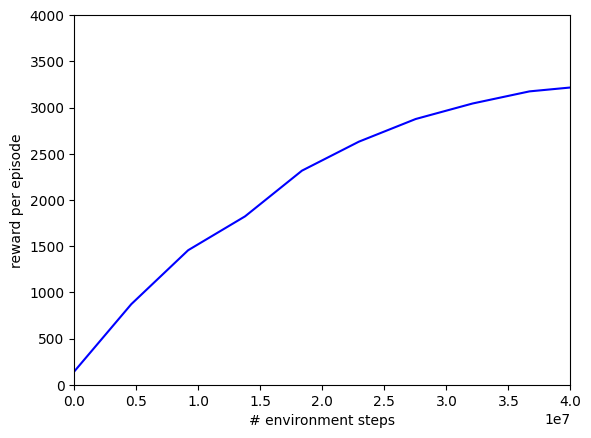

Training (and tracing) done in 201.78 seconds


In [17]:
import matplotlib.pyplot as plt #Alright, I lied, we also need matplotlib as the dependency...
from IPython.display import clear_output
from dill import dump, load

env = envs.create(env_name="ant", backend="spring")
agent = Agent(jr.PRNGKey(42), env.observation_size, env.action_size)
agent = ObservationNormalizingWrapper(agent)
agent = ActionTanhConstraintWrapper(agent, range_low=-1.0, range_high=1.0)

xdata, ydata = [], []

def progress(step_num, metrics):
  xdata.append(step_num)
  ydata.append(metrics["eval/episode_reward"])
  clear_output(wait=True)

  plt.xlim([0, 40_000_000])
  plt.ylim([0, 4000])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")

  plt.plot(xdata, ydata, "b")
  plt.show()


t0 = time.time()

agent, metrics = train(
  agent,
  params=HyperParameters(
      env=env,
      num_timesteps=40_000_000,
      num_evals=10,
      reward_scaling=0.1,
      episode_length=1000,
      unroll_length=5,
      num_minibatches=32,
      num_updates_per_batch=4,
      discounting=0.99,
      learning_rate=3e-4,
      entropy_cost=1e-3,
      batch_size=1024,
      eval_batch_size=256,
      gae_lambda=0.97,
      max_gradient_norm=1.0,
      clipping_epsilon=0.3,
  ),
  progress=progress,
)

print(f"Training (and tracing) done in {time.time() - t0:.2f} seconds")

In [ ]:
class GHyps(eqx.Module):
    

In [ ]:
env = envs.create(env_name="ant", backend="spring")
agent = Agent(jr.PRNGKey(42), env.observation_size, env.action_size)
agent = ObservationNormalizingWrapper(agent)
agent = ActionTanhConstraintWrapper(agent, range_low=-1.0, range_high=1.0)

xdata, ydata = [], []

def progress(step_num, metrics):
    xdata.append(step_num)
    ydata.append(metrics["eval/episode_reward"])
    clear_output(wait=True)

    plt.xlim([0, 40_000_000])
    plt.ylim([0, 4000])
    plt.xlabel("# environment steps")
    plt.ylabel("reward per episode")

    plt.plot(xdata, ydata, "b")
    plt.show()


t0 = time.time()

agent, metrics = train(
    agent,
    params=HyperParameters(
        env=env,
        num_timesteps=40_000_000,
        num_evals=10,
        reward_scaling=0.1,
        episode_length=1000,
        unroll_length=5,
        num_minibatches=32,
        num_updates_per_batch=4,
        discounting=0.99,
        learning_rate=3e-4,
        entropy_cost=1e-3,
        batch_size=1024,
        eval_batch_size=256,
        gae_lambda=0.97,
        max_gradient_norm=1.0,
        clipping_epsilon=0.3,
    ),
    progress=progress,
)

print(f"Training (and tracing) done in {time.time() - t0:.2f} seconds")


In [18]:
from tqdm import tqdm as tqdm

In [19]:

agent_r = Agent(jr.PRNGKey(42), env.observation_size, env.action_size)
agent_r = ObservationNormalizingWrapper(agent_r)
agent_r = ActionTanhConstraintWrapper(agent_r, range_low=-1.0, range_high=1.0)

Now, lets look at the gradients of the simulation for different numbers of steps

In [20]:
env = envs.create(env_name="ant", backend="spring")
episode_length = 1000
env = envs.training.wrap(env, episode_length=episode_length)
env = envs.training.EvalWrapper(env)

def actor_step_gradded(key: jr.PRNGKey, env, env_state, policy: Callable, extra_fields):
    """Makes a single step with the provided policy in the environment."""
    keys_policy = jr.split(key, env_state.obs.shape[0])
    action, _ = eqx.filter_vmap(policy)(keys_policy, env_state.obs)
    print(env_state.info)
    next_state = env.step(env_state, action.transformed)

    return next_state, Transition(
        observation=env_state.obs,
        action=action,
        reward=next_state.reward,
        next_observation=next_state.obs,
        # extract requested additional fields
        extras={x: next_state.info[x] for x in extra_fields},
    )

def generate_unroll_gradded(
    key: jr.PRNGKey, env, env_state, policy: Callable, gradded_policy, unroll_length, extra_fields
):
    """Collects trajectories of given unroll length."""

    def f(carry, _):
        current_key, state = carry
        current_key, next_key = jr.split(current_key)

        next_state, transition = actor_step_gradded(
            current_key, env, state, policy, extra_fields=extra_fields
        )
        return (next_key, next_state), transition
    gradded_env_state, _transition = actor_step_gradded(key, env, env_state, gradded_policy, extra_fields)
    (_, final_state), data = filter_scan(f, (key, gradded_env_state), (), length=unroll_length-1)
    return final_state, data

@eqx.filter_jit
def eval(delta, env, agent, key, N=32, episode_length=1000):
  old_value = agent.next.next.next.actor.mean_network.structure[0].weight
  zeroholder = jnp.zeros_like(agent.next.next.next.actor.mean_network.structure[0].weight)
  zeroholder = zeroholder.at[5,7].set(delta)
  new_agent = eqx.tree_at(where=lambda a: a.next.next.next.actor.mean_network.structure[0].weight, pytree=agent, replace=old_value + zeroholder)
  reset_keys = jr.split(key, N)
  eval_first_state = env.reset(reset_keys)
  return generate_unroll_gradded(
      key,
      env,
      eval_first_state,
      agent.get_action,
      new_agent.get_action,
      unroll_length=episode_length,
      extra_fields=("truncation",),
  )[0].info['eval_metrics'].episode_metrics['reward'].mean()


In [21]:
  def generate_unroll_mag(
    key: jr.PRNGKey, env, env_state, agent, deltas, unroll_length, extra_fields
):
    def f(carry, delta_i):
        current_key, state = carry
        current_key, next_key = jr.split(current_key)

        old_value = agent.next.next.next.actor.mean_network.structure[0].weight
        zeroholder = jnp.zeros_like(old_value)
        zeroholder = zeroholder.at[5,7].set(delta_i)
        new_agent = eqx.tree_at(where=lambda a: a.next.next.next.actor.mean_network.structure[0].weight, pytree=agent, replace=old_value + zeroholder)
        next_state, transition = actor_step_gradded(
            current_key, env, state, new_agent.get_action, extra_fields=extra_fields
        )
        return (next_key, next_state), transition
    (_, final_state), data = filter_scan(f, (key, env_state), deltas, length=unroll_length)
    return final_state, data

@eqx.filter_jit
def all_grads_eval(deltas, env, agent, key, N=8, episode_length=200):
    reset_keys = jr.split(key, N)
    eval_first_state = env.reset(reset_keys)
    return generate_unroll_mag(
        key,
        env,
        eval_first_state,
        agent, deltas,
        unroll_length=episode_length,
        extra_fields=("truncation",),
    )[0].info['eval_metrics'].episode_metrics['reward'].mean()

def generate_unroll_mag_lambdas(
    key: jr.PRNGKey, env, env_state, agent, deltas, lambdas, unroll_length, extra_fields
):
    def f(carry, delta_i):
        current_key, state = carry
        current_key, next_key = jr.split(current_key)

        old_value = agent.next.next.next.actor.mean_network.structure[0].weight
        zeroholder = jnp.zeros_like(old_value)
        zeroholder = zeroholder.at[5,7].set(delta_i)
        new_agent = eqx.tree_at(where=lambda a: a.next.next.next.actor.mean_network.structure[0].weight, pytree=agent, replace=old_value + zeroholder)
        next_state, transition = actor_step_gradded(
            current_key, env, state, new_agent.get_action, extra_fields=extra_fields
        )
        return (next_key, next_state), transition
    (_, final_state), data = filter_scan(f, (key, env_state), deltas, length=unroll_length)
    return final_state, data


@eqx.filter_jit
def all_grads_eval_lambdas(deltas, env, agent, key, lambdas=1.0, N=8, episode_length=200):
    reset_keys = jr.split(key, N)
    eval_first_state = env.reset(reset_keys)
    rewards = generate_unroll_mag_lambdas(
        key,
        env,
        eval_first_state,
        agent, deltas, lambdas,
        unroll_length=episode_length,
        extra_fields=("truncation",),
    )
    return jnp.sum(rewards[1].reward.mean(axis=1) * lambdas)

In [22]:
def generate_unroll_mag_pseudo(
    key: jr.PRNGKey, env, env_state, agent, deltas, factor, unroll_length, extra_fields
):
    def f(carry, cons):
        current_key, state = carry
        current_key, next_key = jr.split(current_key)
        delta_i, i = cons

        old_value = agent.next.next.next.actor.mean_network.structure[0].weight
        zeroholder = jnp.zeros_like(old_value)
        zeroholder = zeroholder.at[5,7].set(delta_i * (factor ** (unroll_length - i)))
        new_agent = eqx.tree_at(where=lambda a: a.next.next.next.actor.mean_network.structure[0].weight, pytree=agent, replace=old_value + zeroholder)
        next_state, transition = actor_step_gradded(
            current_key, env, state, new_agent.get_action, extra_fields=extra_fields
        )
        return (next_key, next_state), transition
    (_, final_state), data = filter_scan(f, (key, env_state), (deltas, jnp.arange(len(deltas))), length=unroll_length)
    return final_state, data


@eqx.filter_jit
def all_grads_eval_pseudo(deltas, env, agent, key, factor=1.0, N=2, episode_length=200):
    if N == 1:
      reset_keys = jr.split(key, 2)
    else:
      reset_keys = jr.split(key, N)
    eval_first_state = env.reset(reset_keys)
    rewards = generate_unroll_mag_pseudo(
        key,
        env,
        eval_first_state,
        agent, deltas, factor,
        unroll_length=episode_length,
        extra_fields=("truncation",),
    )
    if N == 1:
      return jnp.sum(rewards[1].reward[:, 0])
    else:
      return jnp.sum(rewards[1].reward.mean(axis=1))

In [23]:
import brax

In [24]:
@eqx.filter_jit
def actor_step_gradded(key: jr.PRNGKey, env, env_state, policy: Callable, extra_fields):
    """Makes a single step with the provided policy in the environment."""
    keys_policy = jr.split(key, env_state.obs.shape[0])
    action, _ = eqx.filter_vmap(policy)(keys_policy, env_state.obs)
    next_state = env.step(env_state, action.transformed)

    return next_state, Transition(
        observation=env_state.obs,
        action=action,
        reward=next_state.reward,
        next_observation=next_state.obs,
        # extract requested additional fields
        extras={x: next_state.info[x] for x in extra_fields},
    )

def generate_unroll_jac(
    key: jr.PRNGKey, env, env_state, agent, unroll_length, extra_fields
):

    def _len():
      return env_state.pipeline_state.x_i.pos.size + env_state.pipeline_state.x_i.rot.size

    def _get(s, i):
      return jax.lax.cond(
          i < env_state.pipeline_state.x_i.pos.size,
          lambda: s.pipeline_state.x_i.pos.flatten()[i],
          lambda: s.pipeline_state.x_i.rot.flatten()[i - env_state.pipeline_state.x_i.pos.size]
      )

    def pack(s):
        return jnp.concatenate([s.pos.flatten(), s.rot.flatten()])

    def unpack(s):
        lena = env_state.pipeline_state.x_i.pos.flatten().shape[0]
        lenb = env_state.pipeline_state.x_i.rot.flatten().shape[0]
        return brax.Transform(s[:lena].reshape(env_state.pipeline_state.x_i.pos.shape), s[lena:].reshape(env_state.pipeline_state.x_i.rot.shape))


    def f(carry, cons):
        current_key, state = carry
        current_key, next_key = jr.split(current_key)

        next_state, transition = actor_step_gradded(
            current_key, env, state, agent.get_action, extra_fields=extra_fields
        )

        def compute_jac():
            def preproc(g_state, index):
                state_i = eqx.tree_at(lambda x: x.pipeline_state.x_i, state, unpack(g_state))
                out = _get(actor_step_gradded(
                    current_key, env, state_i, agent.get_action, extra_fields=extra_fields
                )[0], index)
                return out
            def p_grad(index, state_i):
                return eqx.filter_grad(jtu.Partial(preproc, index=index))(pack(state_i.pipeline_state.x_i))
            return eqx.filter_vmap(jtu.Partial(p_grad, state_i=state))(jnp.arange(_len()))
        jac = compute_jac()
        print(jac.shape)

        return (next_key, next_state), jac
    (_, final_state), data = filter_scan(f, (key, env_state), None, length=unroll_length)
    return final_state, data

@eqx.filter_jit
def all_grads_eval_jac(env, agent, key, N=2, episode_length=200):
    reset_keys = jr.split(key, N)
    eval_first_state = env.reset(reset_keys)
    final_state, jacs = generate_unroll_jac(
        key,
        env,
        eval_first_state,
        agent,
        unroll_length=episode_length,
        extra_fields=("truncation",),
    )
    return jacs

In [25]:
@eqx.filter_jit
def eval_magic(key, **kwargs):
  return all_grads_eval_jac(env, agent, key=key, **kwargs)

In [29]:
jax.clear_caches()

In [30]:
jacs = []
for i in tqdm(range(32)):
  vmapped = eqx.filter_vmap(jtu.Partial(eval_magic, N=1, episode_length=100))
  jacs.append(vmapped(jr.split(jr.PRNGKey(i), 8)))
jacs = jnp.array(jacs)

  0%|          | 0/32 [00:00<?, ?it/s]

(63, 63)


100%|██████████| 32/32 [01:17<00:00,  2.43s/it]


In [31]:
jacs = jacs.reshape((-1, 100, 63, 63))
jacs = jnp.flip(jacs, axis=1)

In [32]:
eig = jax.lax.map(lambda x: jax.lax.map(lambda y: jax.numpy.linalg.eigh(y)[0][-1], x), jacs)

In [ ]:

print(eig.mean())
print(jnp.exp(jnp.mean(jnp.log(eig[eig > 0]))))

In [ ]:
for i in range(20):
  print(jax.numpy.linalg.eigh(jacs[0, 50 + i])[0][-1])

In [ ]:
print(jacs.shape)

In [ ]:
prd = jnp.eye(63)
for i in range(100):
  prd = prd @ jacs[1, i]
print(jnp.exp(0.01 * jnp.log(jax.numpy.linalg.eigh(prd)[0][-1])))

In [ ]:
print(jnp.exp(jnp.mean(jax.vmap(lambda x: jnp.log(jax.numpy.linalg.eigh(x)[0][-1]))(jacs[:, 0]))))

In [ ]:
@eqx.filter_jit
def eval_magic(key, **kwargs):
  return eqx.filter_grad(all_grads_eval_pseudo)(jnp.zeros((100,)), env, agent, key=key, **kwargs) #1->1e-9; e+05->e-03

raw_grad_t = []
for i in tqdm(range(32)):
  vmapped = eqx.filter_vmap(jtu.Partial(eval_magic, factor=jnp.array(1), N=1, episode_length=100))
  raw_grad_t.append(vmapped(jr.split(jr.PRNGKey(i), 32)))
raw_grad_t = jnp.array(raw_grad_t)

In [ ]:
raw_grad_t = jnp.flip(jnp.array(raw_grad_t).reshape(-1, raw_grad_t.shape[-1]), axis=1)

In [ ]:
plt.plot(raw_grad_t.mean(axis=0))

In [ ]:
@eqx.filter_jit
def evalg4(key, **kwargs):
  return eqx.filter_grad(all_grads_eval_pseudo)(jnp.zeros((200,)), env, agent_r, key=key, **kwargs) #1->1e-9; e+05->e-03


In [ ]:

l4 = []
for i in tqdm(range(32)):
  vmapped = eqx.filter_vmap(jtu.Partial(evalg4, factor=jnp.array(1 / 1.05), N=2, episode_length=200))
  l4.append(vmapped(jr.split(jr.PRNGKey(i), 32)))

In [ ]:
l4 = jnp.array(l4)
data_ts = jnp.flip(l4.reshape(-1, 200), axis=1)
print(jnp.median(data_ts))
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(jnp.median(data_ts, axis=0), 'r', label='median (1k samples)')
ax.set_xlabel("length of grad eval (singular) (implicit mean of every pair)")
ax.set_ylabel("value of ours FOBG for random agent | recalibrated factor")
ax.legend()

In [ ]:
l3 = jnp.array(l3)
data_ts = jnp.flip(l3.reshape(-1, 200), axis=1)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(jnp.log(jnp.mean(jnp.abs(data_ts), axis=0)), 'g', label='mean of abs (1k samples)')
ax.plot(jnp.log(jnp.median(jnp.abs(data_ts), axis=0)), 'r', label='median of abs (1k samples)')
ax.set_xlabel("length of grad eval (singular) (implicit mean of every pair)")
ax.set_ylabel("log of the absolute value of !ours! FOBG")
ax.legend()

In [ ]:
l2 = jnp.array(l2)
data_ts = jnp.flip(l2.reshape(-1, 200), axis=1)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(jnp.mean(data_ts, axis=0), 'g', label='mean(1k samples)')
ax.plot(jnp.median(data_ts, axis=0), 'r', label='median (1k samples)')
ax.set_xlabel("length of grad eval (singular) (implicit mean of every pair)")
ax.set_ylabel("value of standard FOBG")
ax.legend()

assert False

In [ ]:
l3 = jnp.array(l3)
data_ts = jnp.flip(l3.reshape(-1, 200), axis=1)
N = data_ts.shape[0]

med = jnp.median(data_ts, axis=0)
std = 3 * jnp.std(data_ts, axis=0) / jnp.sqrt(N)
mean = jnp.mean(data_ts, axis=0)
mad = 1.5 * 3 * jnp.median(jnp.absolute(data_ts - med)) / jnp.sqrt(N)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(jnp.mean(data_ts, axis=0), 'g', label='mean(1k samples)')
ax.fill_between(jnp.arange(data_ts.shape[1]), mean + std, mean - std, alpha=0.2, color='g')
ax.plot(jnp.median(data_ts, axis=0), 'r', label='median (1k samples)')
ax.fill_between(jnp.arange(data_ts.shape[1]), med + mad, med-mad, alpha=0.2, color='r')
ax.set_xlabel("length of grad eval (singular) (implicit mean of every pair)")
ax.set_ylabel("value of ours FOBG")
ax.legend()

In [ ]:
def evalg2(key, **kwargs):
  return eqx.filter_grad(all_grads_eval)(jnp.zeros((200,)), env, agent, key, **kwargs)
l2 = []
for i in tqdm(range(32)):
  l2.append(eqx.filter_vmap(jtu.Partial(evalg2, episode_length=200, N=2))(jr.split(jr.PRNGKey(i), 32)))

In [ ]:
l2 = jnp.array(l2)
data_ts = jnp.flip(l2.reshape(-1, 200), axis=1)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(jnp.log(jnp.mean(jnp.abs(data_ts), axis=0)), 'g', label='mean (1k samples)')
ax.plot(jnp.log(jnp.median(jnp.abs(data_ts), axis=0)), 'r', label='median (1k samples)')
ax.set_xlabel("length of grad eval (singular) (implicit mean of every pair)")
ax.set_ylabel("log of the absolute value of the FOBG")
ax.legend()

In [ ]:
def evalg(key, **kwargs):
  return eqx.filter_grad(eval)(jnp.zeros(()), env, agent, key, **kwargs)
#evalg = eqx.filter_grad(eval)
#print(evalg(jr.PRNGKey(0), jnp.zeros(()), env, agent, episode_length=1, N=1))
out = eqx.filter_grad(eval)(jnp.zeros(()), env, agent, jr.PRNGKey(0), episode_length=10, N=2)
print(out)

In [ ]:
print(evalg(jr.PRNGKey(0), episode_length=10, N=2))

In [ ]:
vevalg = eqx.filter_vmap(jtu.Partial(evalg, episode_length=200, N=2))(jr.split(jr.PRNGKey(0), 32))

l = []
for i in tqdm(range(256)):
  l.append(eqx.filter_vmap(jtu.Partial(evalg, episode_length=200, N=2))(jr.split(jr.PRNGKey(i), 32)))

In [ ]:
data = jnp.concatenate(l).flatten()
print(data)
print(len(data))

In [ ]:
print(jnp.mean(data))
print(jnp.median(data))
print(jnp.mean(jnp.sort(data)[5:-5]))

In [ ]:
pdf = jax.scipy.stats.gaussian_kde(data[len(data)//3:-len(data)//3]).pdf

In [ ]:
def estimate_maxima(data):
    kde = jax.scipy.stats.gaussian_kde(data)
    no_samples = 100000
    samples = jnp.linspace(jnp.min(data), jnp.max(data), no_samples)
    probs = kde.evaluate(samples)
    maxima_index = probs.argmax()
    maxima = samples[maxima_index]

    return maxima
deltalen = int(len(data) * 0.44)
estimate_maxima(data[deltalen:-deltalen])

In [ ]:
print(pdf(jnp.median(data)))
print(pdf(0))

In [ ]:
deltalen = int(len(data) * 0.4)
print(jnp.mean(jnp.sort(data)[deltalen:-deltalen]))

In [ ]:
from matplotlib import pyplot as plt

hist, bins, _ = plt.hist(data, log=True, bins=len(data) // 10)
plt.show()
hist, bins, _ = plt.hist(data, bins=len(data) // 10)
plt.show()

In [ ]:
al = []
bl = []

from tqdm import tqdm as tqdm

for i in tqdm(range(100)):
  k = jr.PRNGKey(100000 + i)
  a = eval(jnp.zeros(()), env, agent, k, episode_length=200, N=1000)
  b = eval(jnp.ones(()) * 1e-3, env, agent, k, episode_length=200, N=1000)
  al.append(a)
  bl.append(b)

In [ ]:
a = jnp.array(al[len(al)//2:]).mean()
b = jnp.array(bl[len(al)//2:]).mean()

In [ ]:
print((a-b)/(1e-3))

In [ ]:
#out = eqx.filter_grad(eval)(jnp.zeros(()), env, agent, jr.PRNGKey(0), episode_length=10)
#print(out) # 1.5

In [ ]:
#out = eqx.filter_grad(eval)(jnp.zeros(()), env, agent, jr.PRNGKey(0), episode_length=40)
#print(out) # 12

In [ ]:
#outs = []
#for i in range(50):
#  outs.append(eqx.filter_grad(eval)(jnp.zeros(()), env, agent, jr.PRNGKey(i), episode_length=40))
#outs = jnp.array(outs)
#print(jnp.mean(outs), jnp.std(outs))

In [ ]:
#outs = []
#for i in range(50):
#  outs.append(eqx.filter_grad(eval)(jnp.zeros(()), env, agent, jr.PRNGKey(i), episode_length=10))
#outs = jnp.array(outs)
#print(jnp.mean(outs), jnp.std(outs))

In [ ]:
x = jtu.Partial(eval, delta=jnp.zeros(()), env=env, agent=agent, episode_length=400)(jr.PRNGKey(0))

In [ ]:
print(x)

In [ ]:
outs = eqx.filter_vmap(jtu.Partial(evalg, delta=jnp.zeros(()), env=env, agent=agent, episode_length=400))(jr.split(jr.PRNGKey(0), 32))
outs = jnp.array(outs)
print(jnp.mean(outs), jnp.std(outs))

In [ ]:
!pip install tqdm
from tqdm import tqdm as tqdm
outs_r = []
for i in tqdm(range(5000)):
  outs_r.append(eqx.filter_grad(eval)(jnp.zeros(()), env, agent_r, jr.PRNGKey(i), episode_length=400))
outs_r = jnp.array(outs_r)
print(jnp.mean(outs_r), jnp.std(outs_r))

In [ ]:
#outs = []
#for i in range(50):
#  outs.append(eqx.filter_grad(eval)(jnp.zeros(()), env, agent_r, jr.PRNGKey(i), episode_length=10))
#outs = jnp.array(outs)
#print(jnp.mean(outs), jnp.std(outs))

In [ ]:
# 10 -> 1.5
# 40 -> 12
# 160 -> 12000
# 640 -> 6 * 10e18